In [1]:
#LOADING DATASET

from keras.utils import *
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder


from numpy import array
from numpy import argmax
import pandas as pd


import matplotlib.pyplot as plt
plt.style.use('ggplot')

def plot_history(history):
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    x = range(1, len(acc) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, acc, 'b', label='Training acc')
    plt.plot(x, val_acc, 'r', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    plt.subplot(1, 2, 2)
    plt.plot(x, loss, 'b', label='Training loss')
    plt.plot(x, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()

Using TensorFlow backend.


In [2]:
def readfile(filename):
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append(splits[0].lower())

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

def readfile1(filename):
    f = open(filename)

    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append(splits[-1].rstrip())

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []

    return (sentences)

In [3]:
import os
import sys
import numpy as np
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.layers import Dense, Input
from keras.layers import LSTM, Embedding, TimeDistributed, Masking, Dropout
from keras.models import Model
from keras.initializers import Constant
from sklearn.metrics import classification_report
from keras.layers import Bidirectional


In [4]:
BASE_DIR = ''
MAX_SEQUENCE_LENGTH = 40
MAX_NUM_WORDS = 30000
EMBEDDING_DIM = 160
VALIDATION_SPLIT = 0.2

#EPOCHS = 30               # paper: 80
#DROPOUT = 0.5             # paper: 0.68
#DROPOUT_RECURRENT = 0.25  # not specified in paper, 0.25 recommended
#LSTM_STATE_SIZE = 200     # paper: 275
#CONV_SIZE = 3             # paper: 3
#LEARNING_RATE = 0.0105    # paper 0.0105      # paper uses SGD(lr=self.learning_rate), Nadam() recommended

In [5]:
print('Indexing word vectors.')

embeddings_index = {}
with open('/Users/remywang/Documents/scriptie/Data/160/sonar-160.txt') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

print('Found %s word vectors.' % len(embeddings_index))

Indexing word vectors.
Found 626711 word vectors.


In [6]:
print('Processing text dataset')

trainsentences = readfile('/Users/remywang/Documents/scriptie/Data/ned.train2')
trainlabels = readfile1('/Users/remywang/Documents/scriptie/Data/ned.train2')

print('Found %s texts.' % len(trainsentences))

Processing text dataset
Found 15806 texts.


In [36]:
label_idx = {}
label_idx['padding'] = 9
cur_idx = 0
for sentence in trainlabels:
    for label in sentence:
        if label not in label_idx:
            label_idx[label] = cur_idx
            cur_idx += 1
            
labels = np.ones((len(trainlabels), MAX_SEQUENCE_LENGTH)) * 9
for indexs, sentence in enumerate(trainlabels):
    label_sent = []
    for index, label in enumerate(sentence[:MAX_SEQUENCE_LENGTH]):
        labels[indexs, index] = label_idx[label]
print(trainlabels[14])
print(labels[14])

['B-ORG', 'I-ORG', 'O', 'O', 'O', 'O', 'O', 'B-MISC', 'O', 'O', 'O']
[1. 7. 0. 0. 0. 0. 0. 2. 0. 0. 0. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.
 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9. 9.]


In [8]:
# finally, vectorize the text samples into a 2D integer tensor
tokenizer = Tokenizer(num_words=MAX_NUM_WORDS)
tokenizer.fit_on_texts(trainsentences)
sequences = tokenizer.texts_to_sequences(trainsentences)
sequencesy = tokenizer.texts_to_sequences(trainsentences)

word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 26037 unique tokens.


In [9]:
pad_id=0
data = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post', value = pad_id)

labels = to_categorical(np.asarray(labels))


print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

print(data[0])


Shape of data tensor: (15806, 40)
Shape of label tensor: (15806, 40, 10)
[    1  1369     4     5  3263    11    38    21 10900  1022    23     5
  3264    60  1023  2077    36     6 10901     9  1177 10902     2     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0]


In [10]:
# split the data into a training set and a validation set
indices = np.arange(data.shape[0])
np.random.shuffle(indices)
data = data[indices]
labels = labels[indices]
num_validation_samples = int(VALIDATION_SPLIT * data.shape[0])

x_train = data[:-num_validation_samples]
y_train = labels[:-num_validation_samples]
x_val = data[-num_validation_samples:]
y_val = labels[-num_validation_samples:]

#y_train[0]

In [11]:
print('Preparing embedding matrix.')

num_words = min(MAX_NUM_WORDS, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, EMBEDDING_DIM))
for word, i in word_index.items():
    if i > MAX_NUM_WORDS:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Preparing embedding matrix.


In [12]:
embedding_layer = Embedding(num_words,
                            EMBEDDING_DIM,
                            embeddings_initializer=Constant(embedding_matrix),
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True,
                            mask_zero=False)

In [13]:
from keras.layers import Bidirectional

In [14]:
input_= Input(shape=(MAX_SEQUENCE_LENGTH,), name='input')
sequence_embedding = embedding_layer(input_)
lstm1 = Bidirectional(LSTM(64, return_sequences=True, name='lstml'))(sequence_embedding)
lstm2 = Bidirectional(LSTM(64, return_sequences=True, name='lstm2'))(lstm1)
output = TimeDistributed(Dense(labels.shape[2], activation='softmax'),name="Softmax_layer")(lstm2)

model = Model(inputs=input_, outputs=output)

model.compile(loss='categorical_crossentropy',
              optimizer='Nadam',
              metrics=['acc'])

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 40)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 40, 160)           4166080   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 40, 128)           115200    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 40, 128)           98816     
_________________________________________________________________
Softmax_layer (TimeDistribut (None, 40, 10)            1290      
Total params: 4,381,386
Trainable params: 4,381,386
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Use tf.cast instead.
Train on 12645 samples, validate on 3161 samples
Epoch 1/20
12645/12645 [==============================] - 59s 5ms/step - loss: 0.1443 - acc: 0.9678 - val_loss: 0.0742 - val_acc: 0.9808
Epoch 2/20
12645/12645 [==============================] - 54s 4ms/step - loss: 0.0449 - acc: 0.9882 - val_loss: 0.0547 - val_acc: 0.9871
Epoch 3/20
12645/12645 [==============================] - 58s 5ms/step - loss: 0.0205 - acc: 0.9944 - val_loss: 0.0458 - val_acc: 0.9890
Epoch 4/20
12645/12645 [==============================] - 60s 5ms/step - loss: 0.0117 - acc: 0.9965 - val_loss: 0.0539 - val_acc: 0.9896
Epoch 5/20
12645/12645 [==============================] - 61s 5ms/step - loss: 0.0078 - acc: 0.9975 - val_loss: 0.0633 - val_acc: 0.9894
Epoch 6/20
12645/12645 [==============================] - 60s 5ms/step - loss: 0.0056 - acc: 0.9981 - val_loss: 0.0637 - val_acc: 0.9890
Epoch 7/20
12645/12645 [==============================] - 61s 5ms/step - loss: 0.

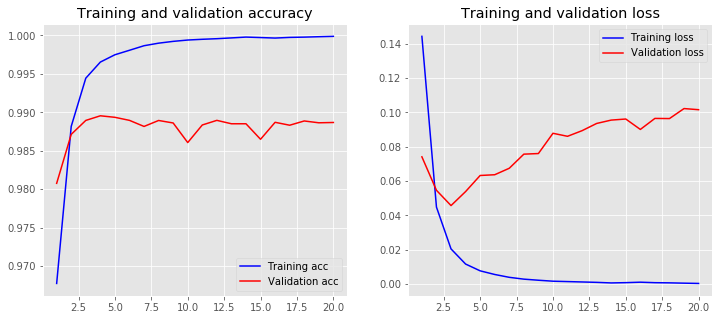

In [15]:
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

plot_history(history)


In [18]:

predictions = model.predict(x_val)



pred_labels = np.array([np.argmax(pred, axis=1) for pred in predictions]).flatten()
true_labels = np.array([np.argmax(pred, axis=1) for pred in y_val]).flatten()


print(classification_report(true_labels, pred_labels))



              precision    recall  f1-score   support

           0       0.97      0.99      0.98     35476
           1       0.82      0.69      0.75       421
           2       0.87      0.57      0.69       673
           3       0.87      0.83      0.85       890
           4       0.93      0.81      0.86       565
           5       0.87      0.72      0.79       610
           6       0.80      0.39      0.52       289
           7       0.75      0.57      0.65       231
           8       0.63      0.43      0.51        89
           9       1.00      1.00      1.00     87196

   micro avg       0.99      0.99      0.99    126440
   macro avg       0.85      0.70      0.76    126440
weighted avg       0.99      0.99      0.99    126440



In [17]:
from sklearn.metrics import f1_score
